# Part I - Ford GoBike Data Exploration
## by Julien Roquelaure

## Introduction

This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area.


## Preliminary Wrangling


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime 

%matplotlib inline

I first load my dataset, and use a set of usual methods to have a sense of what this dataset is about.

In [2]:
df = pd.read_csv('201902-fordgobike-tripdata.csv')

In [3]:
df.shape

(183412, 16)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_id         183215 non-null  float64
 4   start_station_name       183215 non-null  object 
 5   start_station_latitude   183412 non-null  float64
 6   start_station_longitude  183412 non-null  float64
 7   end_station_id           183215 non-null  float64
 8   end_station_name         183215 non-null  object 
 9   end_station_latitude     183412 non-null  float64
 10  end_station_longitude    183412 non-null  float64
 11  bike_id                  183412 non-null  int64  
 12  user_type                183412 non-null  object 
 13  member_birth_year        175147 non-null  float64
 14  memb

In [5]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


We are going to change the type of the start and end time to datetime type:

In [6]:
df['start_time'] = pd.to_datetime(df['start_time'])

In [7]:
df['end_time'] = pd.to_datetime(df['end_time'])

We attempted to change the types of start_station_id, end_station_id, member_birth_year to integer, but attempting to do this and putting back the NaN values turn them back to float types, so we will leave them as they are.

We also considered creating categories for user_type, member_gender and bike_share_for_all_trip, but it seems unnecessary given the small number of values and the lack of hierarchy compared to the previous diamonds dataset.


In [8]:
# df['start_station_id'] = df['start_station_id'].fillna(-1)

In [9]:
# df['start_station_id'] = df['start_station_id'].astype(int)

In [10]:
# df['start_station_id'].replace(-1, np.nan)

In order to have a single day and time of day per ride (some rides spanned several hours or days), I chose to keep the intermediate time between the start and the end to timestamp a ride:

In [11]:
df['mid_time'] = df['start_time'] + (df['end_time'] - df['start_time'])/2

I want a distance "as the crow flies" between two stations, so I looked from a formula that gives distance as a function of the longitude and latitude:

I found this: [haversine formula](https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula)

I choose my unit to be km, so I put the Earth radius in km in the equation:

In [12]:
earth_radius = 6371

In [13]:
def distance(lat1, lon1, lat2, lon2):
    p = math.pi/180
    a = 0.5 - math.cos((lat2-lat1)*p)/2 + math.cos(lat1*p) * math.cos(lat2*p) * (1-math.cos((lon2-lon1)*p))/2
    return 12742 * math.asin(math.sqrt(a))

In [14]:
df['distance'] = df.apply(lambda x: distance(x['start_station_latitude'], x['start_station_longitude'], 
                                             x['end_station_latitude'], x['end_station_longitude']), axis=1)

I want to convert the birth date variable into age, and the duration from seconds to minutes, in order to be closer to intuition:

In [15]:
df['duration_min'] = df['duration_sec'] / 60

In [16]:
df['age'] = 2019 - df['member_birth_year']

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             183412 non-null  int64         
 1   start_time               183412 non-null  datetime64[ns]
 2   end_time                 183412 non-null  datetime64[ns]
 3   start_station_id         183215 non-null  float64       
 4   start_station_name       183215 non-null  object        
 5   start_station_latitude   183412 non-null  float64       
 6   start_station_longitude  183412 non-null  float64       
 7   end_station_id           183215 non-null  float64       
 8   end_station_name         183215 non-null  object        
 9   end_station_latitude     183412 non-null  float64       
 10  end_station_longitude    183412 non-null  float64       
 11  bike_id                  183412 non-null  int64         
 12  user_type       

### What is the structure of your dataset?

The dataset consists of 183,412 bike rides in the San Francisco Bay Area.

It comes from Ford GoBike which was the bike sharing company in the Bay until June 2019 (it is now Bay Wheels in a partnership with Lyft).

We have information about:
- the ride: duration, start and end time.
- the stations: id, name, and coordinates of the start and end stations.
- the bike id.
- the user: Consumer/Subscriber, gender, birth year, and whether they bike share for all their trip.

### What is/are the main feature(s) of interest in your dataset?

I am most interested in the how customers use bike sharing: when and how long they are using it, and if some customers features influence their use of the service.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

The duration and distance should give me an idea about the typical ride.

I expect the day of week to be important, due to the commute time od the work week.

Customer info like subscriber status and age may be an influence too.

## Univariate Exploration

### 1. How is the duration of a ride distributed?

In [18]:
df['duration_min'].min()
df['duration_min'].max()
df['duration_min'].mean()

12.10130725724969

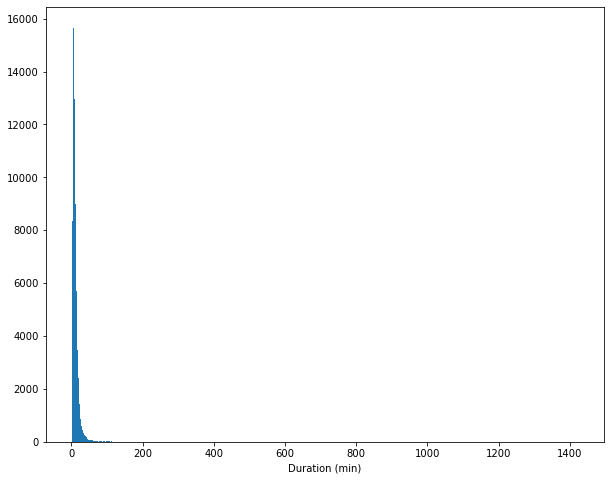

In [19]:
binsize=1
bins=np.arange(0, df.duration_min.max()+binsize, binsize)

plt.figure(figsize=[10,8])
plt.hist(data=df, x='duration_min', bins=bins)
plt.xlabel('Duration (min)')
plt.show()

This distribution is highly skewed to the right.

Let's see it on a log scale:

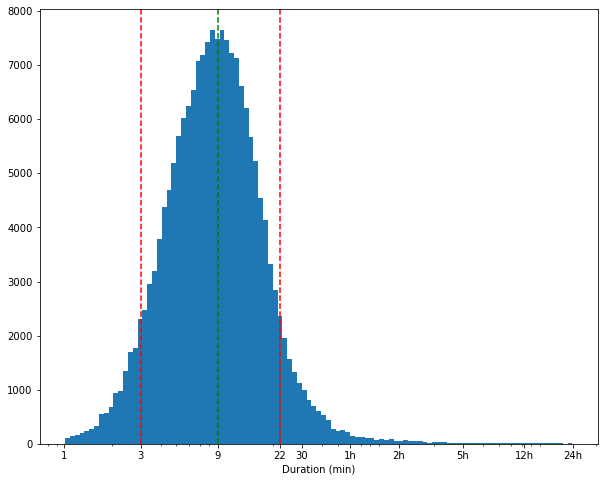

In [20]:
binsize=.03
bins= 10 ** np.arange(np.log10(df.duration_min.min()), np.log10(df.duration_min.max())+binsize, binsize)
plt.figure(figsize=[10,8])
plt.xscale('log')
plt.hist(data=df, x='duration_min', bins=bins)
plt.xticks([1, 3, 9, 22, 30, 60, 120, 300, 720, 1440], 
           [1, 3, 9, 22, 30, '1h', '2h', '5h', '12h', '24h'])
plt.axvline(x=3, color='r', linestyle='dashed')
plt.axvline(x=22, color='r', linestyle='dashed')
plt.axvline(x=9, color='g', linestyle='dashed')
plt.xlabel('Duration (min)')


plt.show()

The distribution of ride duration looks log normally distributed around a 9 minutes ride,
with most values between 3 and 22 minutes.

The distribution has a left cut-off at around 1 minute, and a long right tail up to almost 24 hours.

### 2. When do customers ride their bike during the day?

In [21]:
# df['mid_time_hour'] = df['mid_time'].apply(lambda x: x.round(freq='H').hour)
df['mid_time_hour'] = df['mid_time'].apply(lambda x: x.hour)

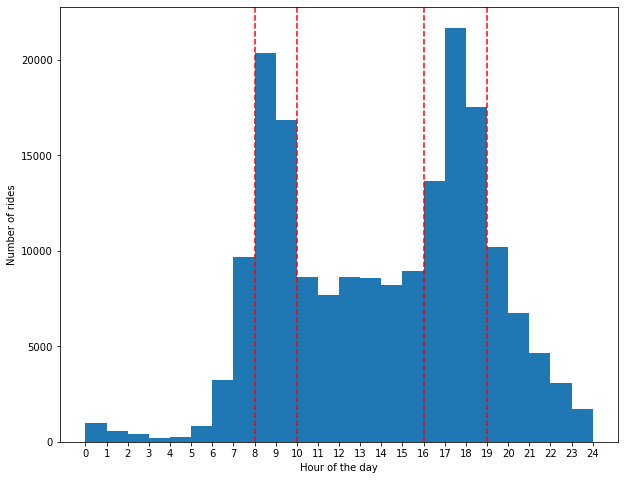

In [22]:
bins = np.arange(0, 25, 1)

plt.figure(figsize=[10,8])
plt.hist(data=df, x='mid_time_hour', bins=bins)
plt.xlabel('Hour of the day')
plt.xticks(bins)
for i in [8, 10, 16, 19]:
    plt.axvline(x=i, color='r', linestyle='dashed')
plt.ylabel('Number of rides')

plt.show()

The peak hours coincide with classcial commute times: 8 to 10 in the morning and 4 to 7 in the afternoon.

### 3. What day of week is more popular?

In [23]:
df['mid_time_dayofweek'] = df['mid_time'].apply(lambda x: x.dayofweek)

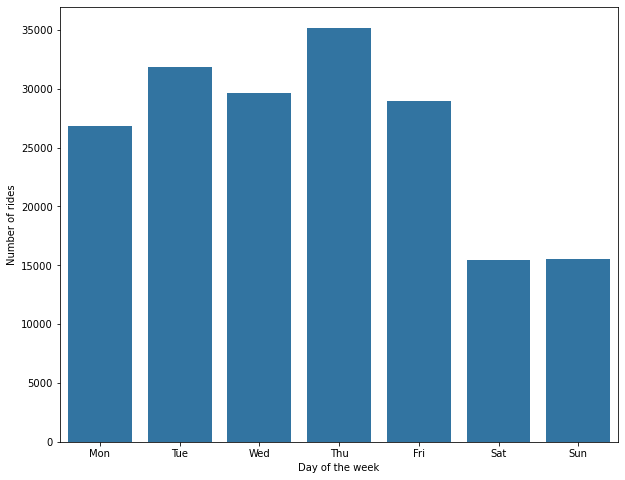

In [24]:
default_color = sns.color_palette()[0]

plt.figure(figsize=[10,8])
sns.countplot(data=df, x='mid_time_dayofweek', color = default_color)
plt.xlabel('Day of the week')
plt.xticks(np.arange(0,7), labels= ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylabel('Number of rides')

plt.show()

People use bike sharing during the work week more than during the weekend.

Nevertheless, we still have about half the number of rides on weekends.

### 4. How old are our customers?

In [25]:
age_min = df['age'].min()
age_max = df['age'].max()

In [26]:
age_mean = df['age'].mean()

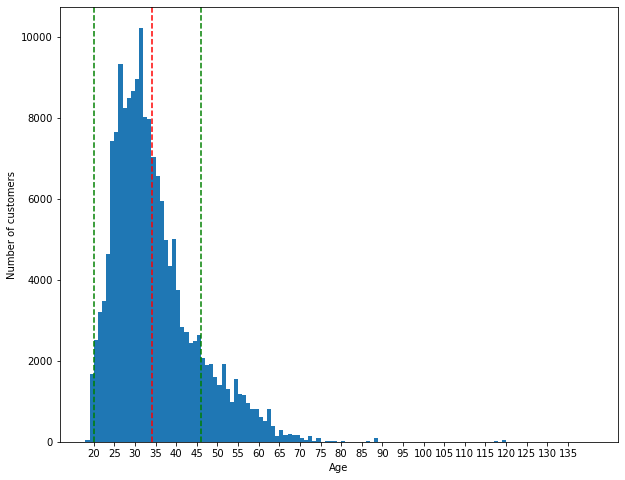

In [27]:
bins=np.arange(age_min, age_max+1, 1)

plt.figure(figsize=[10,8])
plt.hist(data=df, x='age', bins=bins)
plt.xlabel('Age')
plt.xticks(np.arange(20, 140, 5))
plt.ylabel('Number of customers')
plt.axvline(x=age_mean, color='r', linestyle='dashed')
plt.axvline(x=20, color='g', linestyle='dashed')
plt.axvline(x=46, color='g', linestyle='dashed')

plt.show()

The distribution of ages is right skewed with a mean of 34, and most customers between 20 and 46 years old.

There are some suspicious values with ages above 100.

In [28]:
df['age'][df['age'] > 100].values

array([119., 119., 119., 119., 119., 119., 119., 119., 141., 119., 118.,
       119., 119., 119., 119., 119., 119., 119., 118., 119., 119., 119.,
       118., 119., 119., 119., 119., 119., 119., 119., 119., 119., 119.,
       119., 119., 119., 119., 119., 119., 117., 117., 119., 119., 119.,
       119., 119., 119., 119., 117., 119., 119., 119., 117., 119., 117.,
       118., 117., 117., 118., 109., 117., 117., 119., 119., 117., 119.,
       119., 119., 119., 119., 117., 118.])

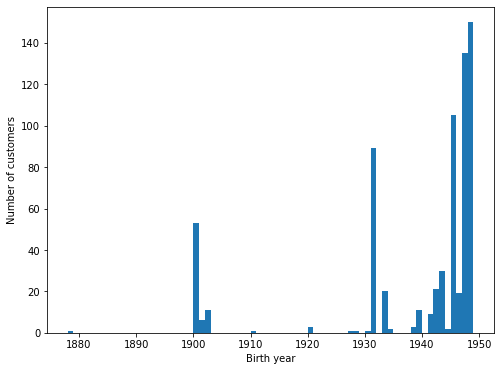

In [29]:
bins=np.arange(df['member_birth_year'].min(), 1950, 1)

plt.figure(figsize=[8,6])
plt.xlabel('Birth year')
plt.ylabel('Number of customers')
plt.hist(df[df['member_birth_year']<1950]['member_birth_year'], bins = bins)
plt.show()

1900 is sometimes a default lower limit in forms. For some reason 1931 seems popular.

We will arbitrarily decide to erase the birth year of people born before 1940.

In [30]:
df['age'] = 2019 - df[df['member_birth_year']>=1940]['member_birth_year'] 

In [31]:
df['member_birth_year'].dropna().shape[0] - df['age'].dropna().shape[0]

203

We loose only 203 values, it shouldn't hamper our analysis.

### 5. What gender are our customers?

For the next, three plots, because I want the same kind of plot with only the feature and the ylabel that differ, I will build a function:

In [32]:
def category_countplot(column, xlabel):
    order = df[column].value_counts().index

    plt.figure(figsize=[8,6])
    sns.countplot(data=df, x=column, color = default_color, order=order)

    plt.xlabel(xlabel)
    plt.ylabel('Number of Customers')

    plt.show()
    

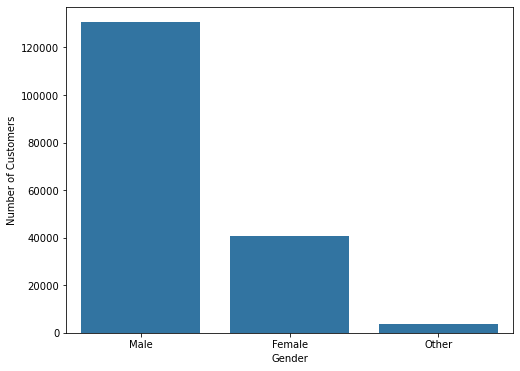

In [33]:
category_countplot('member_gender', 'Gender')

There are more than 3 times male as there are female or other.

### 6. Are there more subscribers or customers?

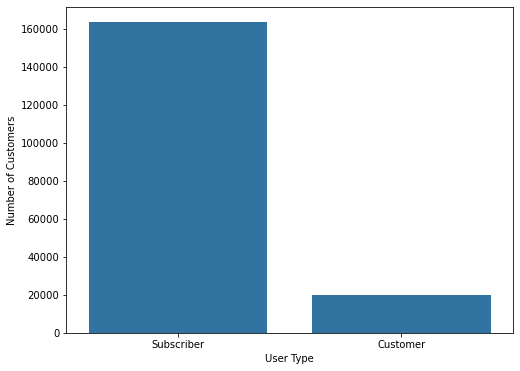

In [34]:
category_countplot('user_type', 'User Type')

Most of the customers subscribe to the service.

### 7. Do user commute entirely by bike?

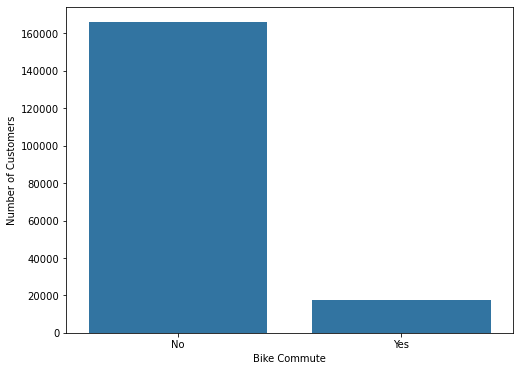

In [35]:
category_countplot('bike_share_for_all_trip', 'Bike Commute')

A vast moajority of the customers do not commute entirely by bike sharing.

### 8. What is the distribution of distances (as the crow flies )?

In [36]:
distance_min = df['distance'].min()
distance_max = df['distance'].max()
distance_mean = df['distance'].mean()

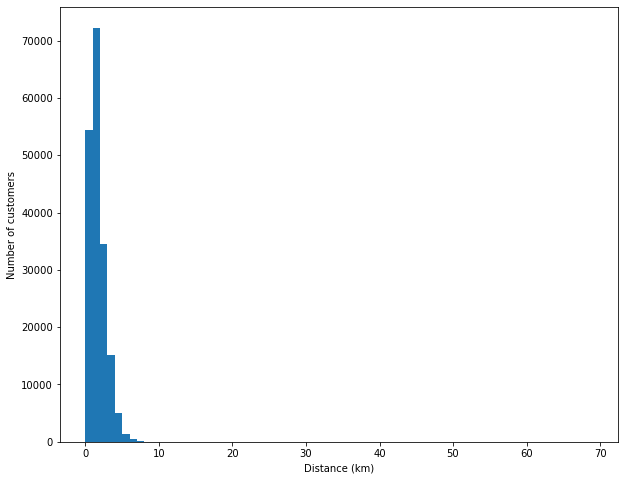

In [37]:
bins=np.arange(distance_min, distance_max, 1)

plt.figure(figsize=[10,8])
plt.hist(data=df, x='distance', bins=bins)
plt.xlabel('Distance (km)')

plt.ylabel('Number of customers')


plt.show()

In [38]:
df[df['distance']>10]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,user_type,member_birth_year,member_gender,bike_share_for_all_trip,mid_time,distance,duration_min,age,mid_time_hour,mid_time_dayofweek
19827,2229,2019-02-26 15:11:44.523,2019-02-26 15:48:54.373,227.0,Foothill Blvd at Fruitvale Ave,37.783757,-122.222603,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,...,Subscriber,1989.0,Male,Yes,2019-02-26 15:30:19.448000,15.673955,37.150000,30.0,15,1
50859,3225,2019-02-21 17:51:18.986,2019-02-21 18:45:04.085,167.0,College Ave at Harwood Ave,37.848152,-122.252160,22.0,Howard St at Beale St,37.789756,...,Subscriber,1988.0,Other,Yes,2019-02-21 18:18:11.535500,14.099709,53.750000,31.0,18,3
84701,16022,2019-02-17 12:39:48.765,2019-02-17 17:06:51.472,163.0,Lake Merritt BART Station,37.797320,-122.265320,3.0,Powell St BART Station (Market St at 4th St),37.786375,...,Customer,NaN,NaN,No,2019-02-17 14:53:20.118500,12.325638,267.033333,NaN,14,6
85529,8957,2019-02-17 12:38:50.477,2019-02-17 15:08:08.352,163.0,Lake Merritt BART Station,37.797320,-122.265320,8.0,The Embarcadero at Vallejo St,37.799953,...,Subscriber,1975.0,Male,Yes,2019-02-17 13:53:29.414500,11.707442,149.283333,44.0,13,6
87602,4378,2019-02-17 00:27:13.613,2019-02-17 01:40:11.883,9.0,Broadway at Battery St,37.798572,-122.400869,193.0,Grand Ave at Santa Clara Ave,37.812744,...,Customer,1993.0,Male,No,2019-02-17 01:03:42.748000,13.590843,72.966667,26.0,1,6
89787,1800,2019-02-16 14:15:06.336,2019-02-16 14:45:06.488,201.0,10th St at Fallon St,37.797673,-122.262997,15.0,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,...,Subscriber,1975.0,Male,Yes,2019-02-16 14:30:06.412000,11.531223,30.000000,44.0,14,5
112038,6945,2019-02-12 14:28:44.402,2019-02-12 16:24:30.158,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,300.0,Palm St at Willow St,37.317298,...,Subscriber,1985.0,Female,No,2019-02-12 15:26:37.280000,69.469241,115.750000,34.0,15,1
121514,1792,2019-02-11 14:39:16.299,2019-02-11 15:09:09.130,230.0,14th St at Mandela Pkwy,37.810743,-122.291415,223.0,16th St Mission BART Station 2,37.764765,...,Subscriber,1988.0,Male,No,2019-02-11 14:54:12.714500,12.409551,29.866667,31.0,14,0
138857,57059,2019-02-07 12:17:12.295,2019-02-08 04:08:11.319,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,47.0,4th St at Harrison St,37.780955,...,Customer,NaN,NaN,No,2019-02-07 20:12:41.807000,11.550564,950.983333,NaN,20,3
153112,2216,2019-02-06 13:05:00.691,2019-02-06 13:41:57.678,219.0,Marston Campbell Park,37.809824,-122.280192,134.0,Valencia St at 24th St,37.752428,...,Subscriber,1989.0,Female,Yes,2019-02-06 13:23:29.184500,13.894462,36.933333,30.0,13,2


There is an outlier at almost 70 km. 

It seems like this person took the public transit BART bringing her bike along, or she really enjoy riding a bike (and is really fast).

I can't discard this extreme outlier because, unlike for age, this is not an impossible value. But giben that there are only 11 distances above 10 km, I will zoom in the range 0 - 10 km:

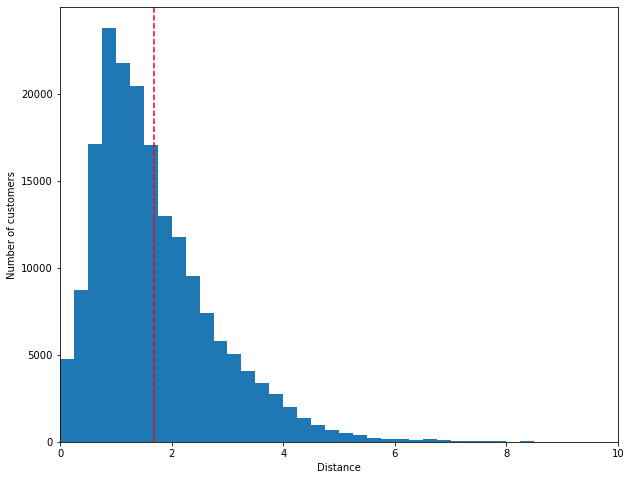

In [39]:
bins=np.arange(distance_min, distance_max, .25)

plt.figure(figsize=[10,8])
plt.hist(data=df, x='distance', bins=bins)
plt.xlabel('Distance')
plt.xlim([0,10])
plt.ylabel('Number of customers')

plt.axvline(x=distance_mean, color='r', linestyle='dashed')

plt.show()

In [40]:
distance_mean

1.6906590083869026

In [41]:
df['distance'].median()

1.4307377073030152

The average distance is quite low (around a mile) and the median even less so.

### 9. What is the pattern of bike sharing for the whole month?

In [42]:
date_min = df['mid_time'].min().date()

In [43]:
date_max = df['mid_time'].max().date()

In [44]:
bins = pd.date_range(start=date_min, end=date_max+pd.Timedelta(days=1))
bins

DatetimeIndex(['2019-02-01', '2019-02-02', '2019-02-03', '2019-02-04',
               '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08',
               '2019-02-09', '2019-02-10', '2019-02-11', '2019-02-12',
               '2019-02-13', '2019-02-14', '2019-02-15', '2019-02-16',
               '2019-02-17', '2019-02-18', '2019-02-19', '2019-02-20',
               '2019-02-21', '2019-02-22', '2019-02-23', '2019-02-24',
               '2019-02-25', '2019-02-26', '2019-02-27', '2019-02-28',
               '2019-03-01', '2019-03-02'],
              dtype='datetime64[ns]', freq='D')

The day label was too crowded, so I built a function to highlight only Sundays:

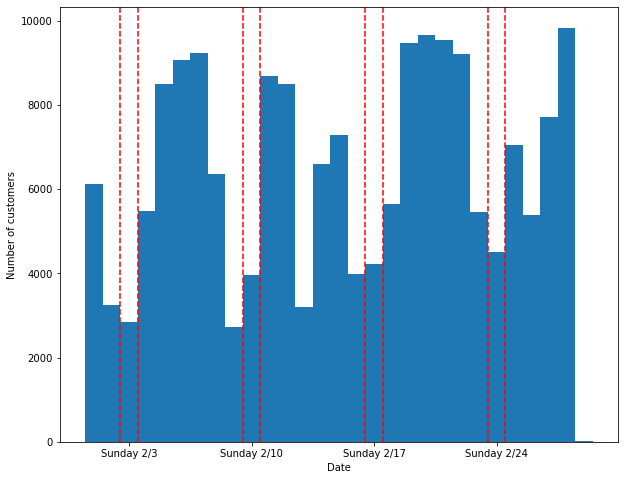

In [45]:
ticks = []
labels = []

plt.figure(figsize=[10, 8])
plt.hist(data=df, x='mid_time', bins = bins)

for i in bins:
    if i.dayofweek == 6:
        ticks.append(i+pd.Timedelta(days=.5))
        labels.append("Sunday {}/{}".format(i.month, i.day))
        plt.axvline(x=i, color='r', linestyle='dashed')
        plt.axvline(x=i+pd.Timedelta(days=1), color='r', linestyle='dashed')

plt.xticks(ticks, labels)
plt.ylabel('Number of customers')
plt.xlabel('Date')
plt.show()

We can see our usual pattern of bike riding during the work week.

I was intrigued by the troughs on 2/13, 2/18 and 2/26, so I checked the weather:

[February 2019 San Francisco Weather](https://www.timeanddate.com/weather/usa/san-francisco/historic?month=2&year=2019)

There was light rain on Sat 2/2, Mon 2/4, Tue 2/26, Wed 2/27 and rain on Wed 13/2.
There was also a holiday: Presidents' Day on Mon 18/2.



### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

The distributions of distance and duration are very right skewed, and rides are around 10 minutes and 1 mile on average.

Without surprise, bike sharing is more popular on week days, and during commute hours.

I had to look for weather information to explain the troughs during February.

The customer base is mostly male and 20 to 40 years old.


### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

I decided to keep the very long duration and the distance outlier for now, because they are not impossible even if it is possible that they reflect: taking a bike aboard a train, or not checking out a bike properly so the duration trails until a limit.

I arbitrarily decided to discard age for people born before 1940. Some values were impossible (like before 1900) and some peaks were suspicious: 1900, 1910, 1920 and for some reason 1931. Only 200 values in a dataset with 180k rows doesn't seem much. Besides, birth year was one of the few features where there were some missing values to begin with.

## Bivariate Exploration

### 1. Correaltion matrix between numeric variables

For comparisons, I will add a log transform of the two right skewed features: duration and distance

In [46]:
df['duration_min_log'] = df['duration_min'].apply(np.log10)
df['distance_log'] = df['distance'].apply(np.log10)

In [47]:
numeric_vars = ['duration_min', 'duration_min_log', 'distance', 'distance_log', 'age', 'mid_time_hour']
categoric_vars = ['user_type', 'member_gender', 'bike_share_for_all_trip', 'mid_time_dayofweek']

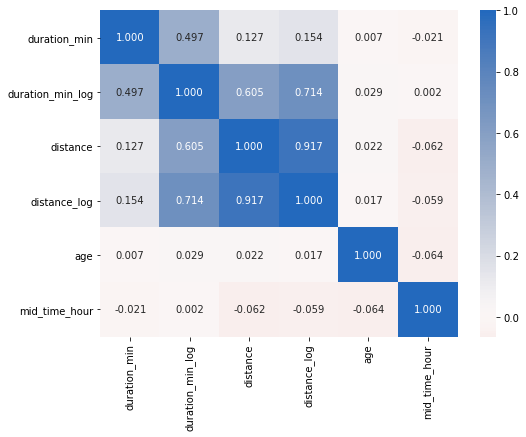

In [48]:
plt.figure(figsize=[8,6])
sns.heatmap(df[numeric_vars].corr(), annot=True, fmt='.3f', cmap = 'vlag_r', center = 0)
plt.show()

No  strong correlation appears. Even the expected correlation between distance and duration is pretty weak.

But after applying a logarithm function to distance and duration, a relationship appears between them.

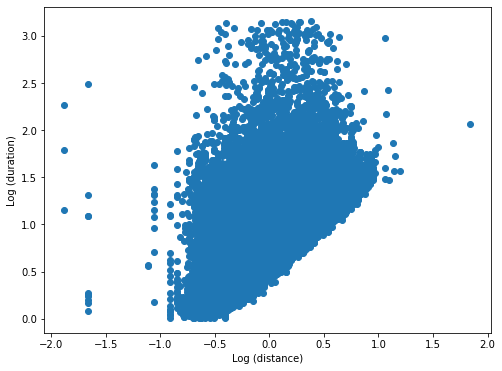

In [49]:
plt.figure(figsize=[8,6])
plt.scatter(data=df, x='distance_log', y='duration_min_log')
plt.xlabel('Log (distance)')
plt.ylabel('Log (duration)')
plt.show()

I find it hard to interpret. It may be due to the dampening effect of high values.

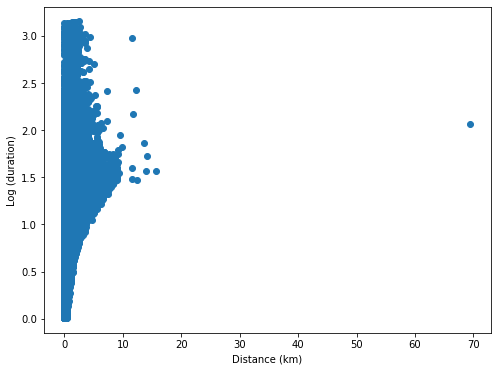

In [50]:
plt.figure(figsize=[8,6])
plt.scatter(data=df, x='distance', y='duration_min_log')
plt.xlabel('Distance (km)')
plt.ylabel('Log (duration)')
plt.show()

The correlation is already quite strong between the logarithm of duration and the distance. Maybe is is due to the fact that this distance is a straight line and does not reflect the path taken by a bike, but there might still be a power law relationship between the distance between two end points and duration.

### 2. Relationship between categorical and numerical variables

From now on, I will keep only the logarithms of duration and distance, in order not to clutter the analysis.

I copied a function from the diamonds projects, in order to have the same color across the grid, but had a wall of warnings.

In [51]:
numeric_vars = ['duration_min_log', 'distance_log', 'age', 'mid_time_hour']
categoric_vars = ['user_type', 'member_gender', 'bike_share_for_all_trip', 'mid_time_dayofweek']

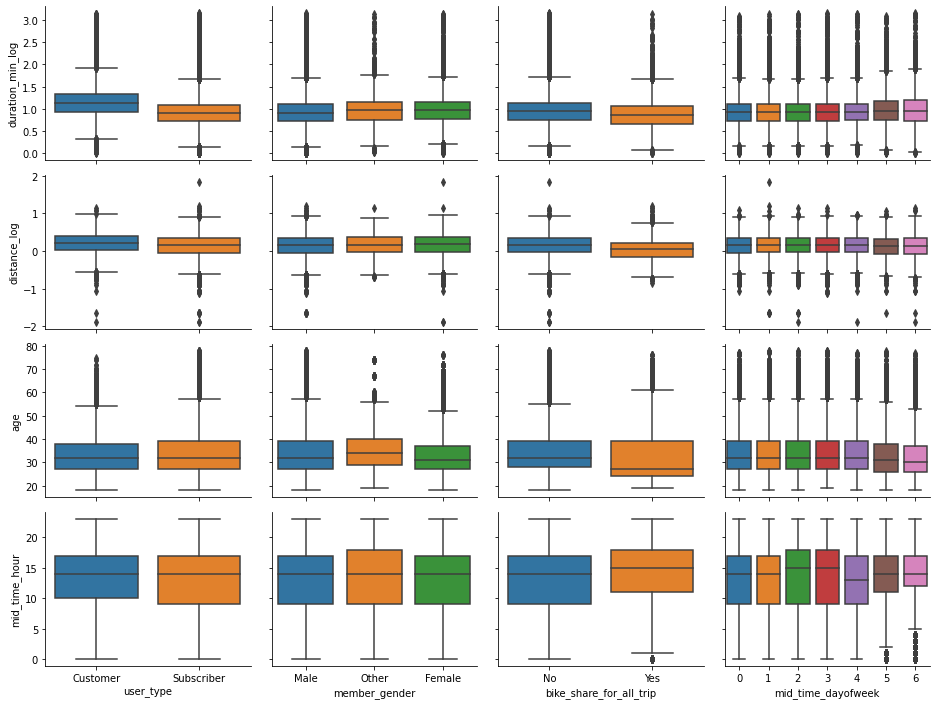

In [52]:
g = sns.PairGrid(data=df, x_vars = categoric_vars, y_vars = numeric_vars, aspect=4/3)


g.map(sns.boxplot)
plt.show()

We see that customers' ride is longer. It makes sense because a subscriber might use bike sharing on the go, whereas a customer might need a stronger motive to use bike sharing.

We will investigate further the hour - day of week relationship.

### 3. Customer vs Subscriber demographics

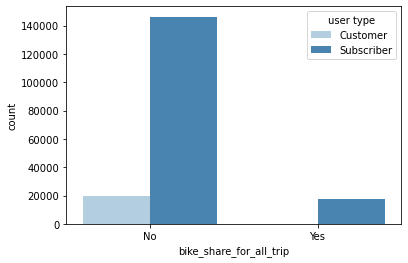

In [53]:
sns.countplot(data=df, x='bike_share_for_all_trip', hue='user_type', palette='Blues')
plt.legend(title='user type', loc=1)

plt.show()

Here we can see that people commuting by bike only are mostly subsribers.

### 4. Time dependance of bike sharing

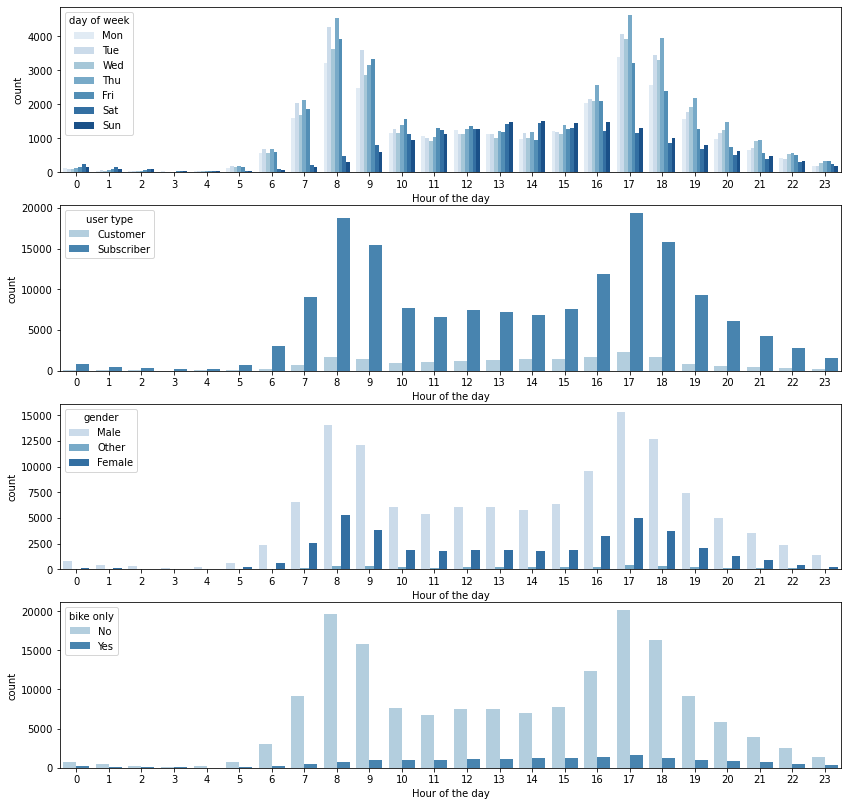

In [54]:
fig, ax = plt.subplots(nrows=4, figsize=[14,14])


# plt.figure(figsize = [14, 14])

# ax = plt.subplot(4, 1, 1)
sns.countplot(data=df, x='mid_time_hour', hue='mid_time_dayofweek', palette='Blues', ax=ax[0])
ax[0].legend(title='day of week', labels= ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
         loc=2)
ax[0].set_xlabel('Hour of the day')



# ax = plt.subplot(4, 1, 2)
sns.countplot(data=df, x='mid_time_hour', hue='user_type', palette='Blues', ax=ax[1])
ax[1].legend(title='user type', loc=2)
ax[1].set_xlabel('Hour of the day')

# ax = plt.subplot(4, 1, 3)
sns.countplot(data=df, x='mid_time_hour', hue='member_gender', palette='Blues', ax=ax[2])
ax[2].legend(title='gender', loc=2)
ax[2].set_xlabel('Hour of the day')

# ax = plt.subplot(4, 1, 4)
sns.countplot(data=df, x='mid_time_hour', hue='bike_share_for_all_trip', palette='Blues', ax=ax[3])
ax[3].legend(title='bike only', loc=2)
ax[3].set_xlabel('Hour of the day')

plt.show()



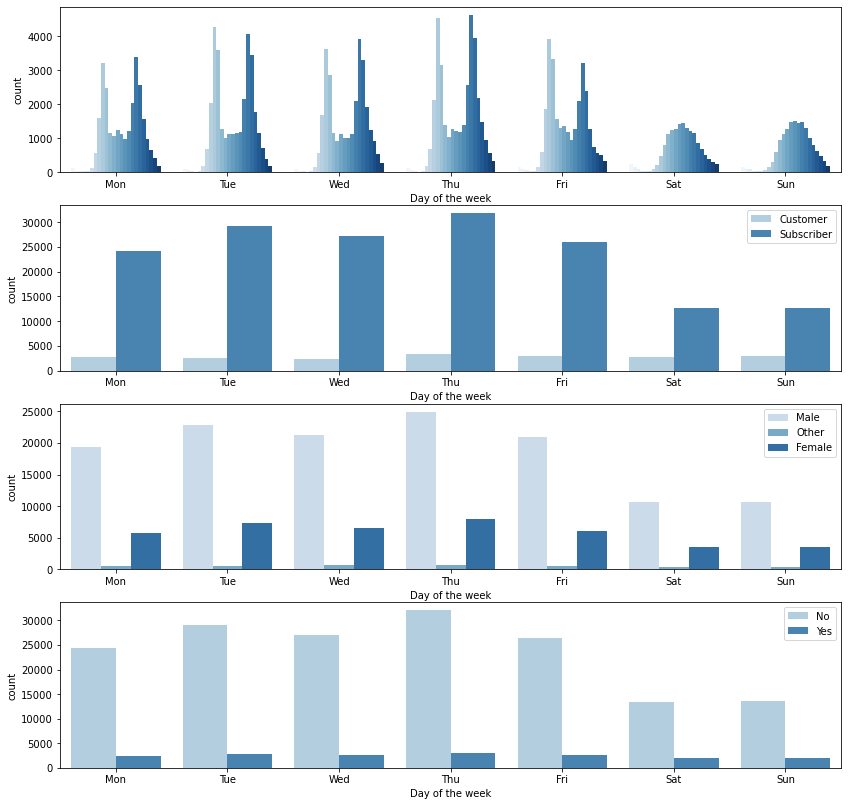

In [55]:
fig, ax = plt.subplots(nrows=4, figsize=[14,14])

# plt.figure(figsize = [14, 14])

# ax = plt.subplot(4, 1, 1)
sns.countplot(data=df, x='mid_time_dayofweek', hue='mid_time_hour', palette='Blues', ax=ax[0])
ax[0].set_xticks(np.arange(7))
ax[0].set_xlabel('Day of the week')
ax[0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax[0].get_legend().remove()
# ax[0].get_xaxis().set_visible(False)

# ax = plt.subplot(4, 1, 2)
sns.countplot(data=df, x='mid_time_dayofweek', hue='user_type', palette='Blues', ax=ax[1])
ax[1].legend(loc=1)
ax[1].set_xlabel('Day of the week')
ax[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# ax = plt.subplot(4, 1, 3)
sns.countplot(data=df, x='mid_time_dayofweek', hue='member_gender', palette='Blues', ax=ax[2])
ax[2].legend(loc=1)
ax[2].set_xlabel('Day of the week')
ax[2].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# ax = plt.subplot(4, 1, 4)
sns.countplot(data=df, x='mid_time_dayofweek', hue='bike_share_for_all_trip', palette='Blues', ax=ax[3])
ax[3].legend(loc=1)
ax[3].set_xlabel('Day of the week')
ax[3].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


plt.show()

In both plots, we see the intersting pattern of bike riding for work on week days and a normal distribution on week ends.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

We see a remarkable pattern when we plot day of week vs hour of the day: Work week bike sharing is really centered around commute times, while on week ends, we can imgaine a more leisure-oriented riding, distributed around the middle of the day.


### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

We found a relationship between the log of duration and straight line distance. I was expecting a linear relationship, like what we usually think about reaching an end goal at constant speed, or even when we travel by car, the duration is roughly proportionnal to the distance.

But given the short distances and urban setting, it is possible that it is effectively a power law. I did not investigated further to find the exponent because it wasn't relevat for this specific analysis where I wanted to see patterns of consumption.

## Multivariate Exploration

### 1. Is there relation among age, user type and time of day?

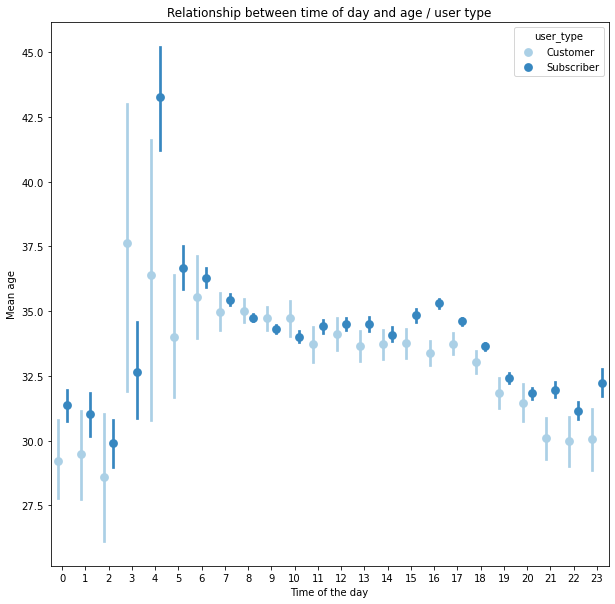

In [56]:
fig = plt.figure(figsize = [10,10])
ax = sns.pointplot(data = df, x = 'mid_time_hour', y = 'age', hue = 'user_type',
           palette = 'Blues', linestyles = '', dodge = 0.4)
plt.title('Relationship between time of day and age / user type')
plt.ylabel('Mean age')
plt.xlabel('Time of the day')

plt.show();

### 2. Is there relation among age, user type and day of week?

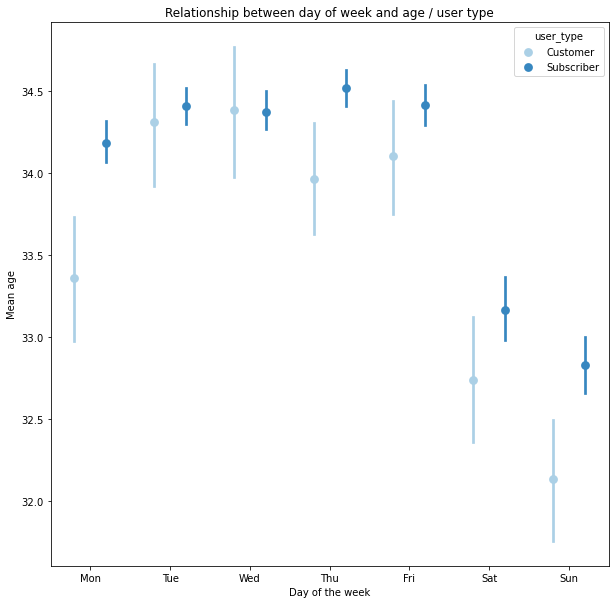

In [57]:
fig = plt.figure(figsize = [10,10])
ax = sns.pointplot(data = df, x = 'mid_time_dayofweek', y = 'age', hue = 'user_type',
           palette = 'Blues', linestyles = '', dodge = 0.4)
plt.title('Relationship between day of week and age / user type')
plt.ylabel('Mean age')
plt.xlabel('Day of the week')
plt.xticks(ticks=np.arange(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.show();

Given that there are more subscribers than customers, there is a lot of uncertainty for the latter compared to the former.

Focusing on the age variable, we see a slight tendency of riders being older following the work pattern, and younger on week ends.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

My main features of interest revolve around the time behavior of Ford GoBike users.

We can see in these plots that work behavior is associated with a slightly older customer base and week ends associated with a younger one.

### Were there any interesting or surprising interactions between features?

Even if the spread of mean age is higher for the non-subscriber demographics, we consistently see a tendency for them to be younger than subscribers. It possibly reflect that people tend to adhere to a more consistent work schedule as they age.

## Conclusions

In this exploration, we first found that bike sharing trips tend to be quite short,
around 9 minutes on average, for a distance of about a mile.

On a side exploration, we saw a correlation between the logarithms of duration and distance,
it wasn't the theme of my anaysis, but we may further explore a power law relationship between duration and distance,
in the particular case of biking in urban settings for short distances/durations.

We found that in a typical day, people use the bikes mostly during commute hours: 
8 to 10 in the morning and 4 to 7 in the evening.
Day-wise, customers behavior reflect work patterns: bike sharing is more popular during the work week than during the weekend.
Interestingly, we found a drop in bike sharing during rainy days and holiday compared to a sunny work week.

About our customers, the age range skew towards younger people: an average of 34, and most are between 20 and 45 years old.
Customers are mostly male: there are abour 3 times male customers than female or other.
Most of our customers are subscribers rather than punctual customers.
And bike sharing is only part of their trip.
